# Class Activation Map 만들기

## CAM
- 클래스에 대한 활성화 정도를 나타낸 지도로 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있음. 기본적으로 분류를 수행하는 모델이어야 함.
- Grad-CAM은 이러한 제약이 없음.

## 데이터셋 준비
- Tensorflow Datasets의 stanford_dogs 데이터셋을 사용.
- 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있음.
- stanford_dogs 데이터셋은 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋으로 구성되어 있음.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
#gpu 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import os

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = os.getenv('HOME') + '/aiffel/stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    #as_supervised = True,
    with_info=True,
)

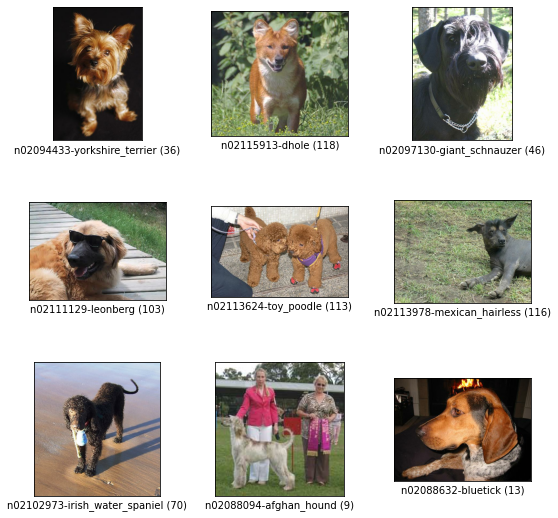

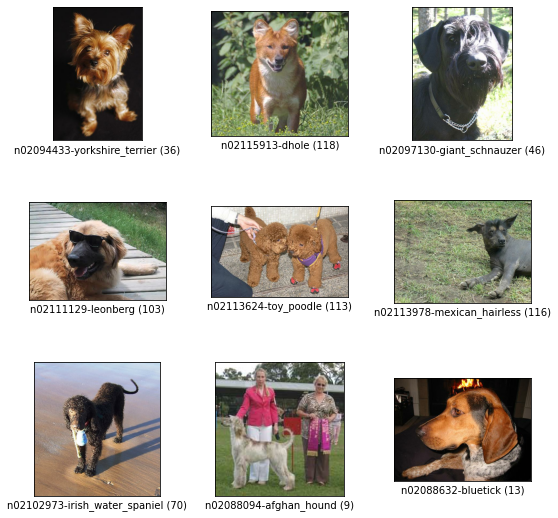

In [4]:
#클래스와 인덱스 확인
tfds.show_examples(ds_train, ds_info)

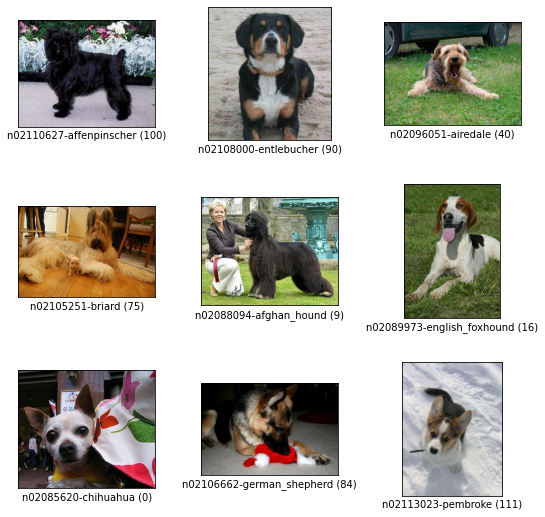

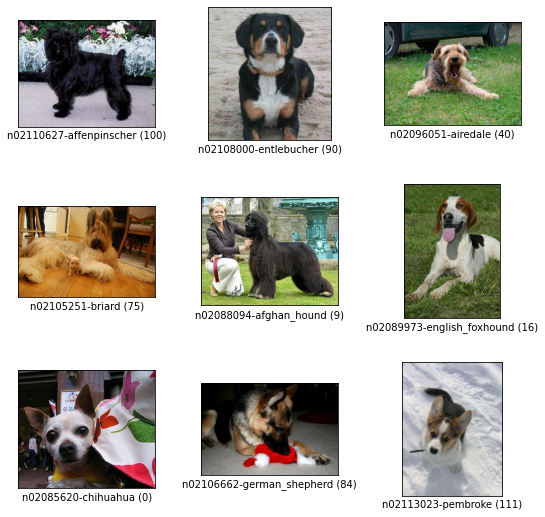

In [5]:
#평가용 데이터셋
tfds.show_examples(ds_test, ds_info)

## 물체의 위치 정보

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스.
- bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법으로 BBoxFeature이라는 타입으로 정의되어 있음.

### - 바운딩박스 표시하는 방법들
- 'xywh' 또는 'minmax'로 표기하는 방법이 주로 사용됨.
- 'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법임.
- 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법임.
- 간단한 바운딩 박스 정보라도 표기법을 데이터셋에서 확인하고 넘어가는 것이 좋음.

### - 해당 데이터셋에서 바운딩 박스
- 해당 bounding box는 minmax를 의미함.
- tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됨.

## CAM위한 모델 만들기
-  미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어(소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어)를 붙여 Grad-CAM 모델을 만들 것.

In [7]:
#ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     #Imagenet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    #ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있음
    pooling='avg',      #GAP 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- 위 레이어들 중 우리가 사용하는 특성 맵은 conv5_block3_out의 output이 feature map이 됨.
-  이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됨.

## CAM 모델 학습
- 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행.
- 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성.

In [3]:
#bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외함.
def normalize_and_resize_img(input):
    #Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
#데이터셋에 전처리와 배치처리를 적용. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

#구성된 배치의 모양을 확인. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 351s 433ms/step - loss: 3.1808 - accuracy: 0.2808 - val_loss: 2.9713 - val_accuracy: 0.2755
Epoch 2/15
750/750 [==============================] - 316s 421ms/step - loss: 0.9282 - accuracy: 0.7370 - val_loss: 1.0663 - val_accuracy: 0.6897
Epoch 3/15
750/750 [==============================] - 316s 421ms/step - loss: 0.2975 - accuracy: 0.9293 - val_loss: 0.9632 - val_accuracy: 0.7184
Epoch 4/15
750/750 [==============================] - 316s 421ms/step - loss: 0.1137 - accuracy: 0.9831 - val_loss: 0.9253 - val_accuracy: 0.7323
Epoch 5/15
750/750 [==============================] - 316s 421ms/step - loss: 0.0418 - accuracy: 0.9966 - val_loss: 0.9192 - val_accuracy: 0.7367
Epoch 6/15
750/750 [==============================] - 316s 421ms/step - loss: 0.0166 - accuracy: 0.9999 - val_loss: 0.9248 - val_accuracy: 0.7407
Epoch 7/15
750/750 [==============================] - 316s 421ms/step - loss: 0.0113 - accuracy: 0.9997 - val_loss: 0.9334 -

In [13]:
#학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("Save completed")

Save completed


## 학습된 모델에서 CAM 생성
- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 함.
- CAM 생성은 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요함.
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 함.
- 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 함.

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


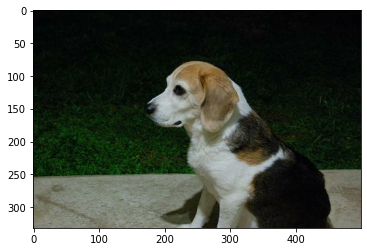

In [5]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [6]:
#이전에 학습한 모델 로드
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- generate_cam() 을 구현하기 위해 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현함. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 함.

In [8]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의.
    #model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        #W * f 를 통해 class별 activation map을 계산.
        cam_image += w * conv_outputs[:, :, i]
    
    #activation score를 normalize.
    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    #원래 이미지의 크기로 resize.
    cam_image = cv2.resize(cam_image, (width, height)) 
    
    return cam_image

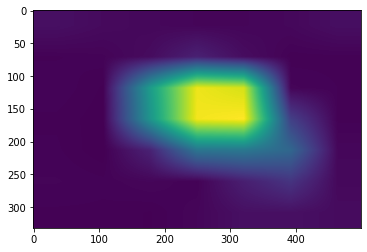

In [9]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [10]:
#그려진 CAM과 원본 이미지 합침
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    
    return merged_image

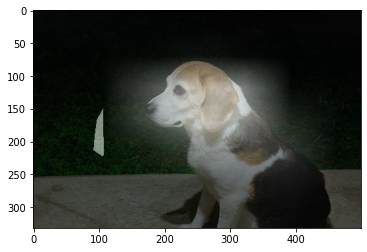

In [11]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있음.

## Grad-CAM
- 적용 모델을 유연하게 선택할 수 있으므로 만들었던 모델을 다시 사용해도 되므로 cam_model을 그대로 활용함.
- 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구함.
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됨.
- 떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 함.
- 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용함.

11


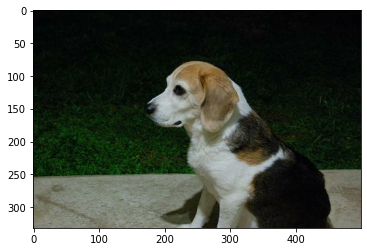

In [12]:
#새로운 이미지
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [13]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의.
    #해당 레이어의 이름으로 찾은 후 output으로 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    #Gradient를 얻기 위해 tape를 사용.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] #원하는 class(여기서는 정답으로 활용) 예측값을 얻음.
        output = conv_output[0] #원하는 layer의 output을 얻음.
        grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 Layer의 gradient를 얻음.

    weights = np.mean(grad_val, axis=(0, 1)) #gradient의 GAP으로 class별 weight를 구함.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        #각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

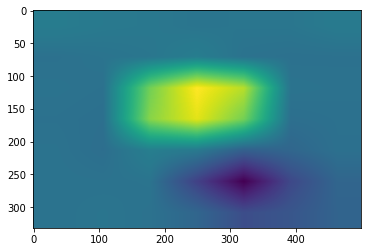

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

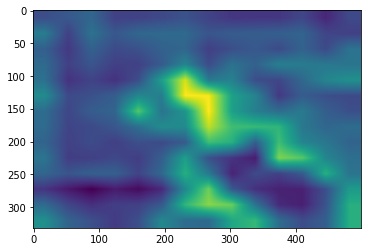

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

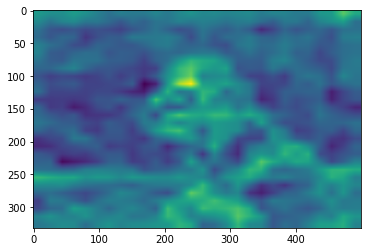

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 바운딩 박스 - detection with CAM

67


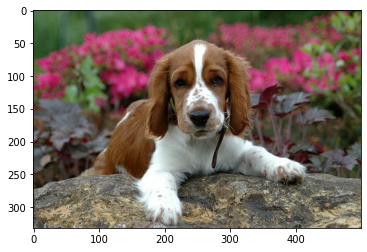

In [17]:
#이미지
item = get_one(ds_test)
print(item['label'])

plt.imshow(item['image'])
plt.show()

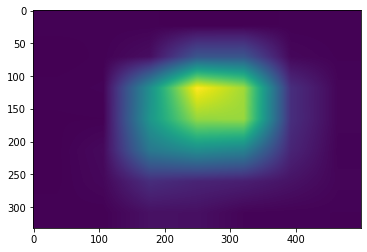

In [18]:
#CAM 이미지
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [19]:
#바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앰.
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    #OpenCV의 findContours()와 minAreaRect()로 사각형을 찾음.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    
    #rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있음.
    rect = cv2.boxPoints(rotated_rect)   #boxPoints()로 이를 꼭지점으로 바꾸어 줌.
    rect = np.int0(rect)
    
    return rect

In [20]:
rect = get_bbox(cam_image)
rect

array([[104,  40],
       [434,  23],
       [447, 288],
       [117, 305]])

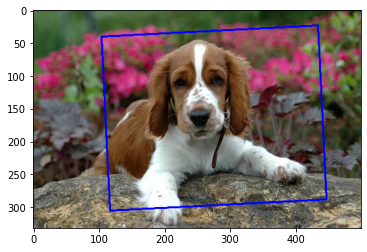

In [21]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 바운딩 박스와 정답 데이터 비교
- IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값임.
- 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됨.

In [22]:
#rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    
    return bbox

In [23]:
#위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.06927710843373494, 0.208, 0.9186746987951807, 0.894]

In [24]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [25]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [26]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7134610587151865

- CAM 추론 결과로 얻어진 bbox가 ground truth bbox 얼마나 유사한지를 IoU를 계산해서 확인함.